### Notebook to genereate binned cross sections from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [79]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys

#### Bin variable selection

In [80]:
# Indexing variable
ivar_select = 'rain'
# pw, vmf, rain, lwacre

#### Time selection

In [81]:
nt=24
t0 = 48
t1 = t0+nt

#### Directories

In [82]:
figdir = "/Users/jruppert/code/tc_figs/"

# main = "/Users/jamesruppert/code/tc_output/"
main = "/Users/jruppert/code/tc_output/"
storm = !ls $main
# print(storm)

istorm=storm[0]
memb = !ls $main/$istorm
imemb=memb[0]
# print(main+istorm+'/'+imemb)

datdir = main+istorm+'/'+imemb+'/ctl/'
print(datdir)

/Users/jruppert/code/tc_output/haiyan/memb_01/ctl/


#### Read variables

In [83]:
# Fill contour variable

# Radar Reflectivity
# varfil_main = Dataset(datdir+'dbz.nc') # this opens the netcdf file
# binvar_f_in = varfil_main.variables['dbz'][t0:t1,:,:,:]
# title = 'Ref'
# units_var1 = 'dBZ'
# cmin = -20; cmax=20

# Radiation
varfil_main = Dataset(datdir+'RTHRATLW.nc') # this opens the netcdf file
binvar_f_in = varfil_main.variables['RTHRATLW'][t0:t1,:,:,:] * 3600.*24 # K/s --> K/d
varcs = Dataset(datdir+'RTHRATLWC.nc') # this opens the netcdf file
cs = varcs.variables['RTHRATLWC'][t0:t1,:,:,:] * 3600.*24 # K/s --> K/d
binvar_f_in -= cs
title = 'LW-CRF'
units_var1 = 'K/d'
cmax=4; cmin=-1.*cmax

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain
varfil_strat = Dataset(datdir+'strat.nc') # this opens the netcdf file
strat_in = varfil_strat.variables['strat'][t0:t1,:,:,:]

# LW-ACRE
binfil = Dataset(datdir+'LWacre.nc') # this opens the netcdf file
lwacre = binfil.variables['LWUPB'][t0:t1,:,:,:] # W/m2

bv_shape = np.shape(binvar_f_in)
print("Binvar shape: ",bv_shape)
nt = bv_shape[0]
nz = bv_shape[1]
nx1 = bv_shape[2]
nx2 = bv_shape[3]

Binvar shape:  (24, 10, 740, 1400)


In [84]:
# Vertical coordinate
pres = varfil_main.variables['pres'][:] # Pa
print("Vertical shape: ",np.shape(pres))

Vertical shape:  (10,)


In [85]:
# Line contour variable

# Vertical motion
varfil_cvar = Dataset(datdir+'W.nc') # this opens the netcdf file
binvar_c_in = varfil_cvar.variables['W'][t0:t1,:,:,:]*1e2 # m/s --> cm/s
units_var2='cm/s'
lcmin = -20; lcmax=20; lcint=2

#### Bin variable and settings

In [86]:
if ivar_select == 'pw':
    # PW
    binfil = Dataset(datdir+'PW.nc') # this opens the netcdf file
    ivar = binfil.variables['PW'][t0:t1,:,:,:]
    fmin=35;fmax=80 # mm
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel='Column water vapor [mm]'
    log_x='linear'
    
elif ivar_select == 'rain':
    # Rainfall rate
    binfil = Dataset(datdir+'rainrate.nc') # this opens the netcdf file
    ivar = binfil.variables['rainrate'][t0:t1,:,:,:]
    fmin=0; fmax=140 # mm / hr
    bins=10.**(np.arange(1,8,0.3)-4)
    xlabel='Rainfall rate [mm/hr]'
    log_x='log'

elif ivar_select == 'vmf':
    # Vertical mass flux
    dp=10000. # delta-p, Pa
    g=9.81 # gravity, m/s2
    wv_int = np.sum(binvar_c_in*1e-2,1) * dp/g
    ivar = np.reshape(wv_int,(nt,1,nx1,nx2))
    fmin=0; fmax=140 # mm / hr
    bins=10.**(np.arange(1,8,0.3)-3)
    # bins=np.flip(-1.*bins)
    xlabel='Vertical mass flux [kg/m/s]'
    log_x='log'

elif ivar_select == 'lwacre':
    # LW-ACRE
    ivar = lwacre
    fmin=-100; fmax=200 # W/m2
    step=5
    bins=np.arange(fmin,fmax+step,step)
    xlabel='LW-ACRE [W/m**2]'
    log_x='linear'

    
print("Binvar shape: ",np.shape(ivar))
print(bins)
nbins = np.size(bins)
print(nbins)

Binvar shape:  (24, 1, 740, 1400)
[1.00000000e-03 1.99526231e-03 3.98107171e-03 7.94328235e-03
 1.58489319e-02 3.16227766e-02 6.30957344e-02 1.25892541e-01
 2.51188643e-01 5.01187234e-01 1.00000000e+00 1.99526231e+00
 3.98107171e+00 7.94328235e+00 1.58489319e+01 3.16227766e+01
 6.30957344e+01 1.25892541e+02 2.51188643e+02 5.01187234e+02
 1.00000000e+03 1.99526231e+03 3.98107171e+03 7.94328235e+03]
24


#### Bin the target variable

In [87]:
binvar_f = np.zeros((nbins-1,nt,nz)) # nbins, nt, nz
binvar_c = np.zeros((nbins-1,nt,nz))
binvar_strat = np.zeros((nbins-1,nt,4))
binvar_acre = np.zeros((nbins-1,nt))

# for ibin in range(nbins):
for itim in range(nt):
    for ibin in range(nbins-1):
        # indices = ((ivar[itim,0,:,:] >= bins[ibin]-0.5*step) & (ivar[itim,0,:,:] < bins[ibin]+0.5*step)).nonzero()
        indices = ((ivar[itim,0,:,:] >= bins[ibin]) & (ivar[itim,0,:,:] < bins[ibin+1])).nonzero()
        tmp_f = binvar_f_in[itim,:,indices[0],indices[1]]
        binvar_f[ibin,itim,:] = np.mean(tmp_f,axis=0,dtype=np.float64)
        tmp_c = binvar_c_in[itim,:,indices[0],indices[1]]
        binvar_c[ibin,itim,:] = np.mean(tmp_c,axis=0,dtype=np.float64)
        tmp_acre = lwacre[itim,:,indices[0],indices[1]]
        binvar_acre[ibin,itim] = np.mean(tmp_acre,axis=0,dtype=np.float64)
        tmp_strat = strat_in[itim,:,indices[0],indices[1]]
        for istrat in range(4):
            iindex = ((tmp_strat == (istrat))).nonzero()
            # print(iindex)
            binvar_strat[ibin,itim,istrat] = np.shape(iindex)[1]

/Users/jruppert/opt/anaconda3/envs/plotting/lib/python3.8/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/jruppert/opt/anaconda3/envs/plotting/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


#### Time-average

In [88]:
binvar_f_mn = np.mean(binvar_f,axis=1)
binvar_c_mn = np.mean(binvar_c,axis=1)
binvar_acre_mn = np.mean(binvar_acre,axis=1)
binvar_s_mn = np.mean(binvar_strat,axis=1)

---
### Plotting routines

In [89]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

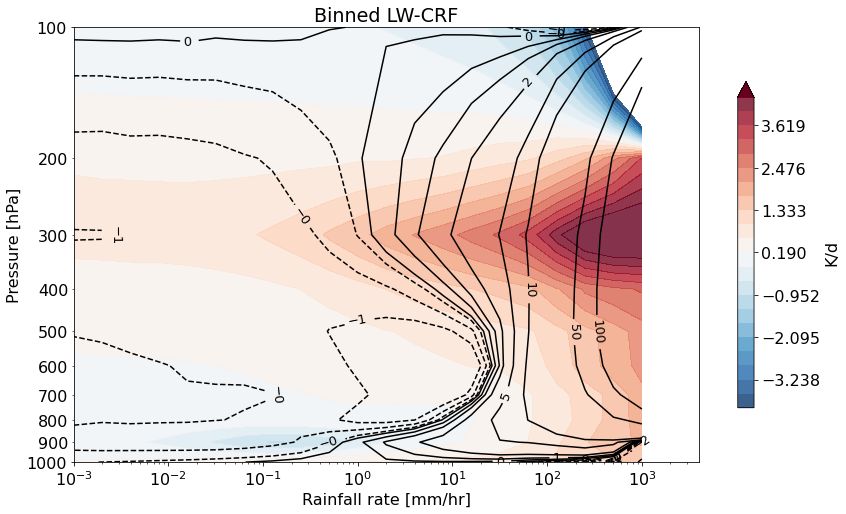

In [90]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title('Binned LW-CRF')
ax.set_ylabel('Pressure [hPa]')

# bins=np.flip(-1.*bins)

# fill contour
nlevs=21
inc=(cmax-cmin)/nlevs
clevs = np.arange(cmin, cmax+inc, inc)
pltvar=binvar_f_mn
im = ax.contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.8, \
                 extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75)
cbar.ax.set_ylabel(units_var1)
ax.invert_yaxis()
ax.set_yscale('log')
ax.set_xscale(log_x)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel(xlabel)

# ax2=ax.twinx()
# im = ax.plot(bins[0:nbins-1], binvar_s_mn)

# line contour
# clevs = np.arange(lcmin, lcmax, lcint)
clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
clevs = np.concatenate((-1*np.flip(clevs),clevs))
cpltvar=binvar_c_mn
# cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
ax.clabel(im, im.levels, inline=True, fontsize=13)

# plt.show()
plt.savefig(figdir+'lwcrf_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white')

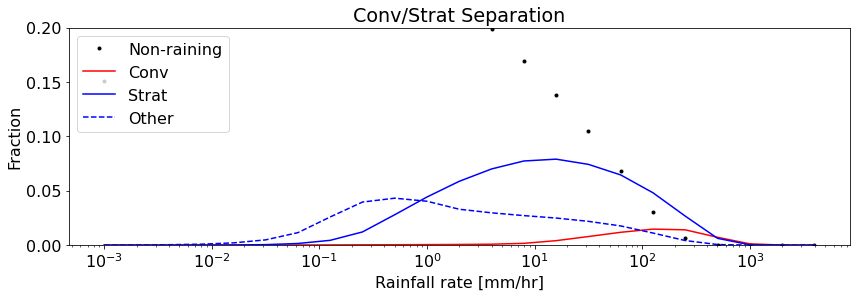

In [91]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

ax.set_title('Conv/Strat Separation')
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

# Raw numbers
# ax.set_ylabel('N cells')
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,0], ".k", label="No rain")
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,1], "-r", label="Conv")
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,2], "-b", label="Strat")
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,3], "--b", label="Other")
# plt.ylim(0, 1e4)

# As fraction of category-total
# ax.set_ylabel('Fraction')# of category-total')
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,0]/np.sum(binvar_s_mn[:,0]) \
#          , ".k", label="No rain")
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,1]/np.sum(binvar_s_mn[:,1]) \
#          , "-r", label="Conv")
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,2]/np.sum(binvar_s_mn[:,2]) \
#          , "-b", label="Strat")
# plt.plot(bins[0:nbins-1], binvar_s_mn[:,3]/np.sum(binvar_s_mn[:,3]) \
#          , "--b", label="Other")
# plt.ylim(0, 0.06)

# As fraction of all-rain-total
ax.set_ylabel('Fraction')
total=np.sum(binvar_s_mn[:,(1,2,3)])
plt.plot(bins[0:nbins-1], binvar_s_mn[:,0]/total \
         , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], binvar_s_mn[:,1]/total \
         , "-r", label="Conv")
plt.plot(bins[0:nbins-1], binvar_s_mn[:,2]/total \
         , "-b", label="Strat")
plt.plot(bins[0:nbins-1], binvar_s_mn[:,3]/total \
         , "--b", label="Other")
plt.ylim(0, 0.2)

plt.legend(loc="upper left")

# plt.show()
plt.savefig(figdir+'convstrat_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white')

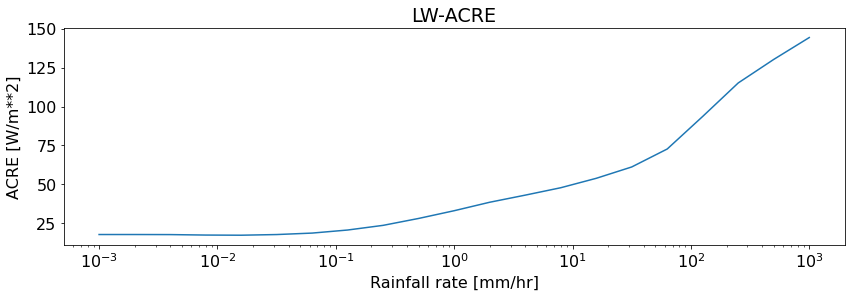

In [92]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

ax.set_title('LW-ACRE')
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

pltvar=binvar_acre_mn

ax.set_ylabel('ACRE [W/m**2]')
plt.plot(bins[0:nbins-1], pltvar)
# plt.ylim(0, 0.2)

# plt.legend(loc="upper left")

# plt.show()
plt.savefig(figdir+'lwacre_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white')

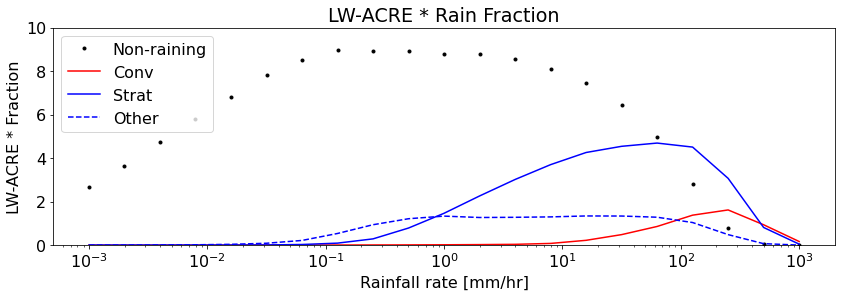

In [93]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

ax.set_title('LW-ACRE * Rain Fraction')
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

# As fraction of all-rain-total
ax.set_ylabel('LW-ACRE * Fraction')
total=np.sum(binvar_s_mn[:,(1,2,3)])
plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,0]/total \
         , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,1]/total \
         , "-r", label="Conv")
plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,2]/total \
         , "-b", label="Strat")
plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,3]/total \
         , "--b", label="Other")
plt.ylim(0, 10)

plt.legend(loc="upper left")

# plt.show()
plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white')